<a href="https://colab.research.google.com/github/kristina-skoptsova/diplom/blob/main/model_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
file = '/content/final2.csv'
df = pd.read_csv(file)
df = pd.DataFrame(df)
df

,Направление,Год поступления,Количество абитуриентов,Баллы ЕГЭ,Возраст,Вступительный балл,Регион рождения,Уровень безработицы,Доля женщин,Доля квоты,Доля волонтерства
0,1,1908,11,-0.397620,-0.302921,1.480258,1.480258,33.793476,0.110471,-0.932472,0.965381
1,1,1909,11,-0.323680,-1.201973,-0.165480,-0.165480,29.929197,-0.607585,0.270533,-0.579118
2,1,1910,11,-1.186287,-1.799674,-1.610080,-1.610080,27.189645,-0.639556,-0.748223,0.253945
3,1,1911,11,-0.042719,0.749308,0.567303,0.567303,32.609474,-0.455643,-0.761783,0.345629
4,1,1912,11,0.957904,0.521211,-0.084162,-0.084162,29.937970,-0.938985,-0.640584,-0.386541
...,...,...,...,...,...,...,...,...,...,...,...
5962,51,2020,19,-0.147270,0.738005,-1.956321,-1.956321,17.091670,-0.354391,0.620962,-0.424094
5963,51,2021,20,0.816437,0.244920,0.138422,0.138422,17.964293,-0.627167,-0.408057,-0.517372
5964,51,2022,20,-0.284249,0.575489,-1.744231,-1.744231,16.264727,1.417724,0.041130,-0.011007
5965,51,2023,20,-0.598730,-0.907030,-0.052447,-0.052447,18.913300,0.567138,0.897687,-0.776967


In [19]:
X = df.drop(columns=['Количество абитуриентов'])
y = df['Количество абитуриентов']

In [20]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping

# Функция для создания последовательностей данных
def create_sequences(data, window_size):
    inputs, outputs, groups = [], [], []
    for direction in data['Направление'].unique():
        dir_data = data[data['Направление'] == direction].sort_values('Год поступления')
        for i in range(len(dir_data) - window_size):
            seq = dir_data.iloc[i:i+window_size].drop(['Направление', 'Год поступления', 'Количество абитуриентов'], axis=1).values
            target = dir_data.iloc[i+window_size]['Количество абитуриентов']
            direction_label = dir_data.iloc[i+window_size]['Направление']  # Направление для следующего шага
            inputs.append(seq)
            outputs.append(target)
            groups.append(direction_label)
    return np.array(inputs), np.array(outputs), np.array(groups)

# Создание последовательностей
YEARS_SIZE = 5
X, y, direction_labels = create_sequences(df, YEARS_SIZE)

# Нормализация целевой переменной
y_scaler = StandardScaler()
y = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test, direction_train, direction_test = train_test_split(
    X, y, direction_labels, test_size=0.2, random_state=42)

# Рассчитываются веса только для тренировочной выборки
unique_directions, direction_counts_train = np.unique(direction_train, return_counts=True)
direction_weights_train = {direction: 1.0 / count for direction, count in zip(unique_directions, direction_counts_train)}

# Применение весов к данным
sample_weights = df['Направление'].map(direction_weights_train).values

# Ограничение веса для тренировочной выборки
train_sample_weights = sample_weights[:len(y_train)]

# Архитектура модели
model_lstm = Sequential([
    Input(shape=(YEARS_SIZE, X.shape[2])),
    LSTM(128, return_sequences=True),
    Dropout(0.1),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1)
])

# Компиляция модели
model_lstm.compile(optimizer='adam', loss='mae', metrics=['mae'])

# Ранняя остановка при переобучении
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True  # Восстановление весов модели с лучшим результатом
)

# Обучение модели
history_lstm = model_lstm.fit(
    X_train,
    y_train,
    sample_weight=train_sample_weights,  # Использование веса
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Оценка модели на тестовой выборке
test_loss, test_mae = model_lstm.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0068 - mae: 0.6033 - val_loss: 0.0039 - val_mae: 0.3597
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042 - mae: 0.3731 - val_loss: 0.0033 - val_mae: 0.3029
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - mae: 0.3100 - val_loss: 0.0030 - val_mae: 0.2754
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0034 - mae: 0.3075 - val_loss: 0.0028 - val_mae: 0.2578
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0031 - mae: 0.2755 - val_loss: 0.0031 - val_mae: 0.2865
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mae: 0.2747 - val_loss: 0.0028 - val_mae: 0.2535
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - mae: 0.2604 - val_loss: 0.0026 - val_mae: 0.2389
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029 - mae: 0.2553 - val_loss: 0.0026 - val_mae: 0.2380
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.

In [24]:
# Сохранение модели
model_lstm.save('lstm_model.keras')

In [13]:
# Предсказание модели
predictions = model_lstm.predict(X_test)
predictions = y_scaler.inverse_transform(predictions)  # Обратное преобразование
y_test_original = y_scaler.inverse_transform(y_test.reshape(-1, 1))

# Создание DataFrame для анализа
test_df = pd.DataFrame({
    'Направление': direction_test,
    'Фактическое': y_test_original.flatten(),
    'Предсказанное': predictions.flatten()
})

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


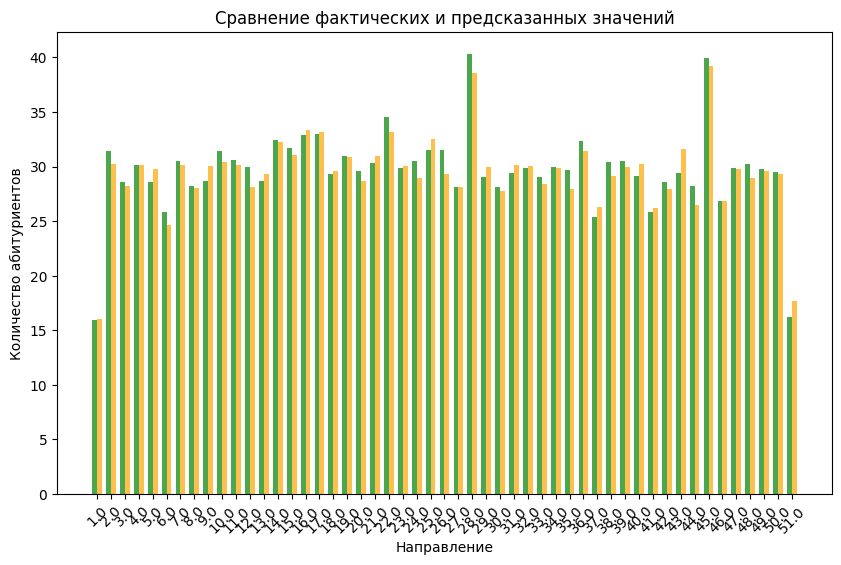

In [21]:
# Группировка данных
mean_values = test_df.groupby('Направление').agg(
    Фактическое_среднее=('Фактическое', 'mean'),
    Предсказанное_среднее=('Предсказанное', 'mean')
).reset_index()

# Построение графика
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(mean_values))

plt.bar(index, mean_values['Фактическое_среднее'], bar_width, label='Фактическое', alpha=0.7, color='green')
plt.bar(index + bar_width, mean_values['Предсказанное_среднее'], bar_width, label='Предсказанное', alpha=0.7, color='orange')

plt.title('Сравнение фактических и предсказанных значений')
plt.xlabel('Направление')
plt.ylabel('Количество абитуриентов')
plt.xticks(index + bar_width / 2, mean_values['Направление'], rotation=45)
plt.show()

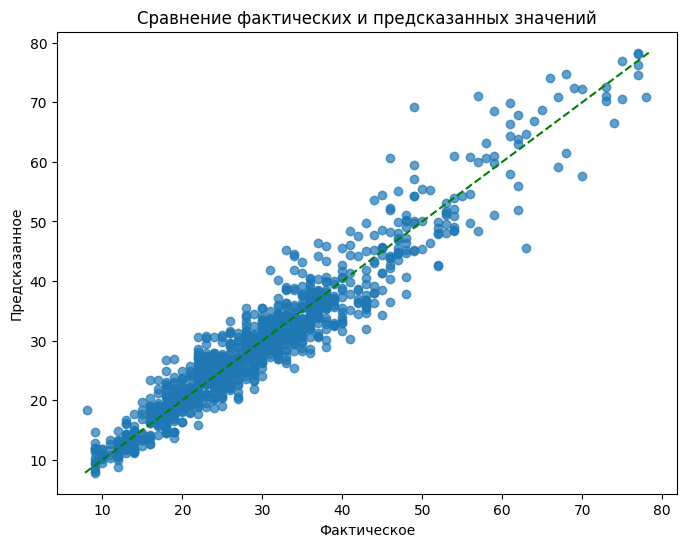

In [22]:
# Построение графика
plt.figure(figsize=(8, 6))
plt.scatter(test_df['Фактическое'], test_df['Предсказанное'], alpha=0.7)

# Линия идеального соответствия
lims = [np.min([test_df['Фактическое'], test_df['Предсказанное']]),
        np.max([test_df['Фактическое'], test_df['Предсказанное']])]
plt.plot(lims, lims, color='green', linestyle='--')

plt.title('Сравнение фактических и предсказанных значений')
plt.xlabel('Фактическое')
plt.ylabel('Предсказанное')
plt.show()

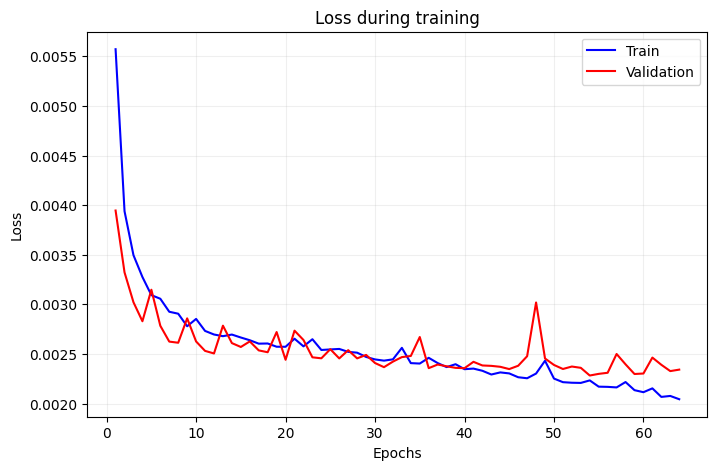

In [23]:
def show_training(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, 'b', label='Train')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.title('Loss during training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()

# Вызов функции после обучения модели
show_training(history_lstm)

In [51]:
!pip install streamlit
!npm install localtunnel

⠙⠹⠸
up to date in 587ms
⠸
⠸3 packages are looking for funding
⠸  run `npm fund` for details
⠸Requirement already satisfied: streamlit in /usr/local/lib/python3.11/dist-packages (1.42.0)


In [57]:
%%writefile app.py
from keras.models import load_model
import streamlit as st
import pandas as pd
import numpy as np

st.title("Прогнозирование абитуриентов")

# Основной интерфейс
st.title("Система прогнозирования количества абитуриентов")
# Создание вкладок
tab1, tab2, tab3 = st.tabs(["Загрузка данных", "Обучение модели", "Тестирование модели"])

# Вкладка 1: Загрузка данных
with tab1:
    st.header("Загрузка данных")
    st.write("Загрузите файл CSV с данными для анализа.")

    uploaded_file = st.file_uploader("Выберите файл CSV", type=["csv"])
    if uploaded_file is not None:
        data = pd.read_csv(uploaded_file)
        st.write("Первые 5 строк загруженного файла:")
        st.dataframe(data.head())

Overwriting app.py


In [53]:
import urllib
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

Password/Enpoint IP for localtunnel is: 34.90.63.15


In [58]:
!streamlit run app.py --server.port 8501 &>/dev/null & npx localtunnel --port 8501

⠙your url is: https://tidy-forks-know.loca.lt
^C
